In [11]:
import numpy as np
import tensorflow as tf
import random
import sys
import eli5

import d2d
import importlib
importlib.reload(d2d)
import pandas as pd
import os

file = "/data/fast0/datasets/Rhone_data_continuous_highpass.h5"
filts = 'highpass'

predictions_dict = {}
real_dict = {}
times_dict = {}

history = {}
val_performance = {}
performance = {}

seeds = np.arange(1)

for seed in seeds:

    random.seed(seed)
    np.random.seed(seed)
    tf.random.set_seed(seed)



    ww = 200
    bs = 32


    input_columns = list(np.arange(0, 2308, 1))
    input_columns.append('Times')


    linear_model, lstm_model, dnn_model, df_all_chan, das_data_all, f  = d2d.import_data(filename = file, input_columns = input_columns)

    da = df_all_chan.to_numpy()

    multi_step_window_shuffled = d2d.WindowGenerator(df_all_chan,
                                                    input_width=ww,
                                                    label_width=1, 
                                                    shift=0,
                                                    label_columns=['Discharge'],
                                                    input_columns=input_columns,
                                                    shuffle=True,
                                                    batch_size=bs)

    history['lstm_'+filts] = d2d.compile_and_fit(lstm_model, multi_step_window_shuffled, learning_rate = 0.001)

    val_performance['lstm_'+filts] = lstm_model.evaluate(multi_step_window_shuffled.val)
    performance['lstm_'+filts] = lstm_model.evaluate(multi_step_window_shuffled.test, verbose=0)

    predictions = lstm_model.predict(multi_step_window_shuffled.test)
    predictions_real = (predictions * multi_step_window_shuffled.dis_std) + multi_step_window_shuffled.dis_mean
    predictions_real = [i[-1] for i in predictions_real]
    predictions_dict['pred_dis_'+filts+str(seed)] = predictions_real

    real_dis = []
    dis_times = []

    for i in multi_step_window_shuffled.test.as_numpy_iterator():
        real_dis.append(i[-1])

    for i in multi_step_window_shuffled.test.as_numpy_iterator():
        for j in np.arange(i[0].shape[0]):
            dis_times.append(i[0][0][j][-1])

    real_dis = np.asarray(real_dis)
    real_dis = real_dis.reshape(real_dis.shape[0] * real_dis.shape[1])
    dis_times = np.asarray(dis_times, dtype=np.float64)


    times_dict['times_'+str(seed)] = (dis_times*multi_step_window_shuffled.chan_std[-1]) + multi_step_window_shuffled.chan_mean[-1]
    real_dict['real_dis_'+filts+str(seed)] = (real_dis * multi_step_window_shuffled.dis_std) + multi_step_window_shuffled.dis_mean


<ipython-input-11-37fdb645eed9>:28: DeprecationWarning: Seeding based on hashing is deprecated
since Python 3.9 and will be removed in a subsequent version. The only 
supported seed types are: None, int, float, str, bytes, and bytearray.
  random.seed(seed)


Keys: <KeysViewHDF5 ['DAS Data', 'Discharge', 'Times']>
2309
Epoch 1/1000
7/7 [==============================] - 3s 233ms/step - loss: 0.8677 - mean_absolute_error: 0.7574 - val_loss: 0.5413 - val_mean_absolute_error: 0.5639
Epoch 2/1000
7/7 [==============================] - 1s 186ms/step - loss: 0.4813 - mean_absolute_error: 0.5350 - val_loss: 0.4192 - val_mean_absolute_error: 0.5188
Epoch 3/1000
7/7 [==============================] - 1s 183ms/step - loss: 0.3237 - mean_absolute_error: 0.4333 - val_loss: 0.3657 - val_mean_absolute_error: 0.4796
Epoch 4/1000
7/7 [==============================] - 1s 186ms/step - loss: 0.2487 - mean_absolute_error: 0.3832 - val_loss: 0.3374 - val_mean_absolute_error: 0.4417
Epoch 5/1000
7/7 [==============================] - 1s 182ms/step - loss: 0.2072 - mean_absolute_error: 0.3427 - val_loss: 0.3093 - val_mean_absolute_error: 0.4135
Epoch 6/1000
7/7 [==============================] - 1s 179ms/step - loss: 0.1534 - mean_absolute_error: 0.2747 - val_lo

In [16]:
print(real_dict)

{'real_dis_highpass0': array([ 8.59175111,  8.30614333,  9.48945333,  9.14119556,  9.46506333,
        5.96753333,  8.32633333,  8.89234667,  6.90753889, 11.83887778,
       10.86554778, 13.77490833, 13.31334722, 16.03186889,  5.32065556,
        6.70355556, 12.44688889,  8.03182667, 11.87926556,  8.06436111,
       11.43828444,  8.34073333,  6.15088333, 13.24655556, 10.90091778])}


In [18]:
for i in multi_step_window_shuffled.test_ds.as_numpy_iterator():
    print(i)

(array([[[ 8191.83258999,  8243.88722179,  8203.5929906 , ...,
           900.68855997,  1611.8455852 , 18476.78009259],
        [ 8223.07222402,  8267.40068533,  8147.46520081, ...,
           861.38894271,  1914.00474172, 18476.78043981],
        [ 8184.05728795,  8290.49253582,  8209.501701  , ...,
           852.98975471,  2097.44953209, 18476.78078704],
        ...,
        [ 8144.81502209,  8186.99457845,  8159.2763536 , ...,
           895.7406404 ,  1925.74272153, 18476.84849537],
        [ 8160.04547038,  8251.59624454,  8154.67566919, ...,
           912.81388107,  2178.85977818, 18476.84884259],
        [ 8211.52010085,  8224.80799215,  8050.05255227, ...,
           869.29149342,  2200.12629609, 18476.84918981]],

       [[ 8163.69152792,  8103.43376311,  8021.74148887, ...,
           791.2259296 ,  1076.30074147, 18460.07974537],
        [ 8132.36864176,  8183.84711608,  8091.24808579, ...,
           834.77165215,  1076.91973008, 18460.08009259],
        [ 8099.93013654,

<IPython.core.display.Javascript object>


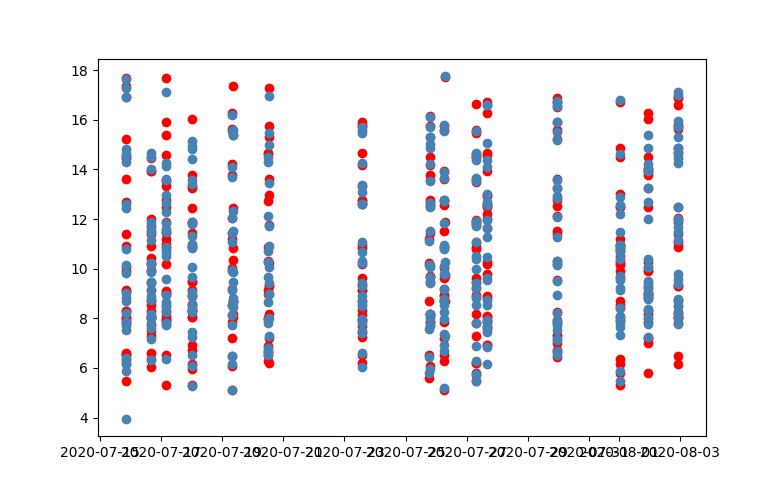

[18461.00668981 18461.00703704 18461.00738426 18461.00773148
 18461.0080787  18461.00842593 18461.00877315 18461.00912037
 18461.00946759 18461.00981481 18461.01016204 18461.01050926
 18461.01085648 18461.0112037  18461.01155093 18461.01189815
 18461.01224537 18461.01259259 18461.01293981 18461.01328704
 18461.01363426 18461.01398148 18461.0143287  18461.01467593
 18461.01502315]
[18460.14918981 18460.14953704 18460.14988426 18460.15023148
 18460.1505787  18460.15092593 18460.15127315 18460.15162037
 18460.15196759 18460.15231481 18460.15266204 18460.15300926
 18460.15335648 18460.1537037  18460.15405093 18460.15439815
 18460.15474537 18460.15509259 18460.15543981 18460.15578704
 18460.15613426 18460.15648148 18460.1568287  18460.15717593
 18460.15752315]
[18475.03446759 18475.03481481 18475.03516204 18475.03550926
 18475.03585648 18475.0362037  18475.03655093 18475.03689815
 18475.03724537 18475.03759259 18475.03793981 18475.03828704
 18475.03863426 18475.03898148 18475.0393287  18475

In [10]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib
import datetime

fig, ax = plt.subplots()

for seed in seeds:
    print(times_dict['times_'+str(seed)])
    
    ax.scatter(times_dict['times_'+str(seed)], real_dict['real_dis_highpass'+str(seed)], color = 'red')
    ax.scatter(times_dict['times_'+str(seed)], predictions_dict['pred_dis_highpass'+str(seed)], color = 'steelblue')
    
ax.xaxis_date()
    
#ax.set_xlim([datetime.date(2020, 7, 17), datetime.date(2020, 7, 18)])


array([-1.0879969 , -1.08767731, -1.08767731, -1.08767731, -1.08767731,
       -1.08767731, -1.08767731, -1.08735773, -1.08735773, -1.08735773,
       -1.08735773, -1.08735773, -1.08703814, -1.08703814, -1.08703814,
       -1.08703814, -1.08703814, -1.08703814, -1.08671856, -1.08671856,
       -1.08671856, -1.08671856, -1.08671856, -1.08671856, -1.08639897])

In [4]:
times_dict['times_'+str(0)]

array([18461.006, 18461.008, 18461.008, 18461.008, 18461.008, 18461.008,
       18461.008, 18461.01 , 18461.01 , 18461.01 , 18461.01 , 18461.01 ,
       18461.012, 18461.012, 18461.012, 18461.012, 18461.012, 18461.012,
       18461.014, 18461.014, 18461.014, 18461.014, 18461.014, 18461.016,
       18461.016], dtype=float32)

<IPython.core.display.Javascript object>


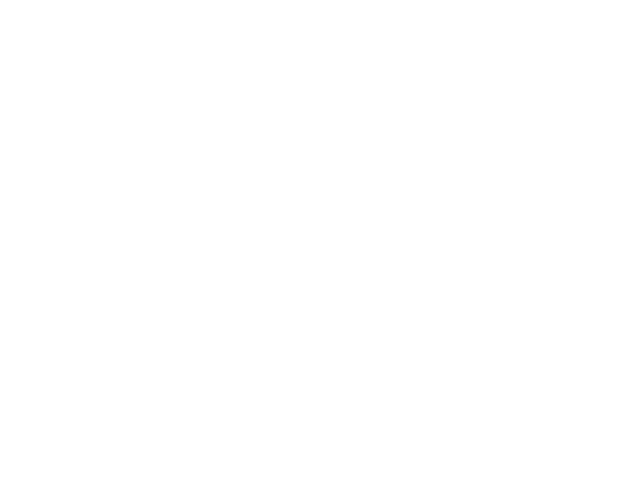

<IPython.core.display.Javascript object>


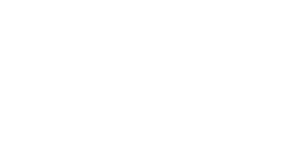

In [73]:
%matplotlib notebook
import matplotlib.pyplot as plt
import matplotlib


fig, ax = plt.subplots()

for seed in seeds:
    
    ax.xaxis_date()
    ax.scatter(times_dict['times_'+str(seed)], real_dict['real_dis_highpass'+str(seed)], color = 'red')
    ax.scatter(times_dict['times_'+str(seed)], predictions_dict['pred_dis_highpass'+str(seed)], color = 'steelblue')

